<a href="https://colab.research.google.com/github/Lilhxr/leaf_detect/blob/main/CKA_Bi_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive/cassava-deit-swin/'

In [ ]:
!pip install --no-deps albumentations==1.0.0 # image argumentation
!pip install timm # pytorch image models

In [4]:
from albumentations.pytorch import ToTensorV2
from datetime import datetime
from pathlib import Path
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.optim import Adam, AdamW 
from torch.optim.lr_scheduler import ExponentialLR 
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.models import resnet34, resnet50
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
from functools import partial
from typing import List, Dict
import warnings
from warnings import warn
warnings.filterwarnings('ignore')

import albumentations as A
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import random
import json

%load_ext tensorboard

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_WORKERS = 1
CASSAVA_NUM_CLASS = 5
OSF_NUM_CLASS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

In [6]:
class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))

In [7]:
class CustomizedDataset(Dataset):
     '''convert ImageFolder to torchvision Dataset'''

     def __init__(self, dataset):
         self.dataset = dataset
         self.classes = self.dataset.classes
         self.targets = self.dataset.targets

     def __getitem__(self, index):
         img, lb = self.dataset[index]
         return (img['image'], lb)
     
     def __len__(self):
         return len(self.dataset)

In [8]:
from mpl_toolkits import axes_grid1
import matplotlib.pyplot as plt

def add_colorbar(im, aspect=10, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [9]:
class CKA:
    def __init__(self, model1: nn.Module,
                 model2: nn.Module,
                 model1_name: str = None,
                 model2_name: str = None,
                 model1_layers: List[str] = None,
                 model2_layers: List[str] = None,
                 device: str ='cpu'):
        """
        :param model1: (nn.Module) Neural Network 1
        :param model2: (nn.Module) Neural Network 2
        :param model1_name: (str) Name of model 1
        :param model2_name: (str) Name of model 2
        :param model1_layers: (List) List of layers to extract features from
        :param model2_layers: (List) List of layers to extract features from
        :param device: Device to run the model
        """

        self.model1 = model1
        self.model2 = model2
        self.device = device
        self.model1_info = {}
        self.model2_info = {}

        if model1_name is None:
            self.model1_info['Name'] = model1.__repr__().split('(')[0]
        else:
            self.model1_info['Name'] = model1_name

        if model2_name is None:
            self.model2_info['Name'] = model2.__repr__().split('(')[0]
        else:
            self.model2_info['Name'] = model2_name

        if self.model1_info['Name'] == self.model2_info['Name']:
            warn(f"Both model have identical names - {self.model2_info['Name']}. " \
                 "It may cause confusion when interpreting the results. " \
                 "Consider giving unique names to the models :)")

        self.model1_info['Layers'] = []
        self.model2_info['Layers'] = []

        self.model1_features = {}
        self.model2_features = {}

        if len(list(model1.modules())) > 150 and model1_layers is None:
            warn("Model 1 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model1_layers' parameter. Your CPU/GPU will thank you :)")

        self.model1_layers = model1_layers

        if len(list(model2.modules())) > 150 and model2_layers is None:
            warn("Model 2 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model2_layers' parameter. Your CPU/GPU will thank you :)")

        self.model2_layers = model2_layers

        self._insert_hooks()
        self.model1 = self.model1.to(self.device)
        self.model2 = self.model2.to(self.device)
        self.model1.eval()
        self.model2.eval()

    def _log_layer(self,
                   model: str,
                   name: str,
                   layer: nn.Module,
                   inp: torch.Tensor,
                   out: torch.Tensor):

        if model == "model1":
            self.model1_features[name] = out

        elif model == "model2":
            self.model2_features[name] = out

        else:
            raise RuntimeError("Unknown model name for _log_layer.")

    def _insert_hooks(self):
        # Model 1
        for name, layer in self.model1.named_modules():
            if self.model1_layers is not None:
                if name in self.model1_layers:
                    self.model1_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model1", name))
            else:
                self.model1_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model1", name))

        # Model 2
        for name, layer in self.model2.named_modules():
            if self.model2_layers is not None:
                if name in self.model2_layers:
                    self.model2_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model2", name))
            else:
                self.model2_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model2", name))

    def _HSIC(self, K, L):
        """
        Computes the unbiased estimate of HSIC metric.
        Reference: https://arxiv.org/pdf/2010.15327.pdf Eq (3)
        """
        if K.shape != L.shape:
           return 0.0
        N = K.shape[0]
        ones = torch.ones(N, 1).to(self.device)
        result = torch.trace(K @ L)
        result += ((ones.t() @ K @ ones @ ones.t() @ L @ ones) / ((N - 1) * (N - 2))).item()
        result -= ((ones.t() @ K @ L @ ones) * 2 / (N - 2)).item()
        result = (1 / (N * (N - 3)) * result).item()
        if np.isnan(result):
            return 0.0
        return result

    def compare(self,
                dataloader1: DataLoader,
                dataloader2: DataLoader = None) -> None:
        """
        Computes the feature similarity between the models on the
        given datasets.
        :param dataloader1: (DataLoader)
        :param dataloader2: (DataLoader) If given, model 2 will run on this
                            dataset. (default = None)
        """

        if dataloader2 is None:
            warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
            dataloader2 = dataloader1

        self.model1_info['Dataset'] = dataloader1.dataset.__repr__().split('\n')[0]
        self.model2_info['Dataset'] = dataloader2.dataset.__repr__().split('\n')[0]

        N = len(self.model1_layers) if self.model1_layers is not None else len(list(self.model1.modules()))
        M = len(self.model2_layers) if self.model2_layers is not None else len(list(self.model2.modules()))

        self.hsic_matrix = torch.zeros(N, M, 3)

        num_batches = min(len(dataloader1), len(dataloader2))

        for (x1, *_), (x2, *_) in tqdm(zip(dataloader1, dataloader2), desc="| Comparing features |", total=num_batches):

            self.model1_features = {}
            self.model2_features = {}
            _ = self.model1(x1.to(self.device))
            _ = self.model2(x2.to(self.device))

            for i, (name1, feat1) in enumerate(self.model1_features.items()):
                X = feat1.flatten(1)
                K = X @ X.t()
                K.fill_diagonal_(0.0)
                self.hsic_matrix[i, :, 0] += self._HSIC(K, K) / num_batches

                for j, (name2, feat2) in enumerate(self.model2_features.items()):
                    Y = feat2.flatten(1)
                    L = Y @ Y.t()
                    L.fill_diagonal_(0.0)
                    #assert K.shape == L.shape, f"Feature shape mistach! {K.shape}, {L.shape}"

                    self.hsic_matrix[i, j, 1] += self._HSIC(K, L) / num_batches
                    self.hsic_matrix[i, j, 2] += self._HSIC(L, L) / num_batches

        self.hsic_matrix = self.hsic_matrix[:, :, 1] / (self.hsic_matrix[:, :, 0].sqrt() *
                                                        self.hsic_matrix[:, :, 2].sqrt())
        #assert not torch.isnan(self.hsic_matrix).any(), "HSIC computation resulted in NANs"

    def export(self) -> Dict:
        """
        Exports the CKA data along with the respective model layer names.
        :return:
        """
        return {
            "model1_name": self.model1_info['Name'],
            "model2_name": self.model2_info['Name'],
            "CKA": self.hsic_matrix,
            "model1_layers": self.model1_info['Layers'],
            "model2_layers": self.model2_info['Layers'],
            "dataset1_name": self.model1_info['Dataset'],
            "dataset2_name": self.model2_info['Dataset']
        }


In [10]:
def plot_results(save_path, title, model1_info, model2_info, hsic_matrix):
    
    fig, ax = plt.subplots()
    im = ax.imshow(hsic_matrix, origin='lower', cmap='magma')
    ax.set_xlabel(f"Layers {model2_info}", fontsize=15)
    ax.set_ylabel(f"Layers {model1_info}", fontsize=15)

    if title is not None:
        ax.set_title(f"{title}", fontsize=18)
    else:
        ax.set_title(f"{model1_info} vs {model2_info}", fontsize=18)
    add_colorbar(im)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()

In [11]:
def feature_dimension_extractor(model):

    feature_dimension = {}
    input = torch.randn(16, 3, 224, 224)

    def hook_fn(name, module, input, output):
        feature_dimension[name] = output.size()

    for name, layer in model.named_modules():
        # hook_fn(module, input, output)
        layer.register_forward_hook(partial(hook_fn, name))
    _ = model(input)

    return feature_dimension 

In [12]:
timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'crossvit_9_240',
 'crossv

In [13]:
model1 = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=5)
# model name: 'vit_tiny_patch16_224', 'swin_tiny_patch4_window7_224' 'resnet50'

In [14]:
feature_dimension_extractor(model1)

{'': torch.Size([16, 5]),
 'avgpool': torch.Size([16, 768, 1]),
 'head': torch.Size([16, 5]),
 'layers': torch.Size([16, 49, 768]),
 'layers.0': torch.Size([16, 784, 192]),
 'layers.0.blocks.0': torch.Size([16, 3136, 96]),
 'layers.0.blocks.0.attn': torch.Size([1024, 49, 96]),
 'layers.0.blocks.0.attn.attn_drop': torch.Size([1024, 3, 49, 49]),
 'layers.0.blocks.0.attn.proj': torch.Size([1024, 49, 96]),
 'layers.0.blocks.0.attn.proj_drop': torch.Size([1024, 49, 96]),
 'layers.0.blocks.0.attn.qkv': torch.Size([1024, 49, 288]),
 'layers.0.blocks.0.attn.softmax': torch.Size([1024, 3, 49, 49]),
 'layers.0.blocks.0.drop_path': torch.Size([16, 3136, 96]),
 'layers.0.blocks.0.mlp': torch.Size([16, 3136, 96]),
 'layers.0.blocks.0.mlp.act': torch.Size([16, 3136, 384]),
 'layers.0.blocks.0.mlp.drop1': torch.Size([16, 3136, 384]),
 'layers.0.blocks.0.mlp.drop2': torch.Size([16, 3136, 96]),
 'layers.0.blocks.0.mlp.fc1': torch.Size([16, 3136, 384]),
 'layers.0.blocks.0.mlp.fc2': torch.Size([16, 3136

In [15]:
feature_dimension = feature_dimension_extractor(model1)
valid_layer_name = [k for k, v in feature_dimension.items() if 'mlp' in k]

In [16]:
valid_layer_name

['layers.0.blocks.0.mlp.fc1',
 'layers.0.blocks.0.mlp.act',
 'layers.0.blocks.0.mlp.drop1',
 'layers.0.blocks.0.mlp.fc2',
 'layers.0.blocks.0.mlp.drop2',
 'layers.0.blocks.0.mlp',
 'layers.0.blocks.1.mlp.fc1',
 'layers.0.blocks.1.mlp.act',
 'layers.0.blocks.1.mlp.drop1',
 'layers.0.blocks.1.mlp.fc2',
 'layers.0.blocks.1.mlp.drop2',
 'layers.0.blocks.1.mlp',
 'layers.1.blocks.0.mlp.fc1',
 'layers.1.blocks.0.mlp.act',
 'layers.1.blocks.0.mlp.drop1',
 'layers.1.blocks.0.mlp.fc2',
 'layers.1.blocks.0.mlp.drop2',
 'layers.1.blocks.0.mlp',
 'layers.1.blocks.1.mlp.fc1',
 'layers.1.blocks.1.mlp.act',
 'layers.1.blocks.1.mlp.drop1',
 'layers.1.blocks.1.mlp.fc2',
 'layers.1.blocks.1.mlp.drop2',
 'layers.1.blocks.1.mlp',
 'layers.2.blocks.0.mlp.fc1',
 'layers.2.blocks.0.mlp.act',
 'layers.2.blocks.0.mlp.drop1',
 'layers.2.blocks.0.mlp.fc2',
 'layers.2.blocks.0.mlp.drop2',
 'layers.2.blocks.0.mlp',
 'layers.2.blocks.1.mlp.fc1',
 'layers.2.blocks.1.mlp.act',
 'layers.2.blocks.1.mlp.drop1',
 'layers

In [17]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)
np.random.seed(0)
random.seed(0)

valid_augs_compose = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
    A.Normalize(
        mean=IMAGENET_DEFAULT_MEAN,
        std=IMAGENET_DEFAULT_STD),
    ToTensorV2(),
])

valid_augs = Transforms(valid_augs_compose)

test_data1 = CustomizedDataset(
    ImageFolder("data/cassava_leaf_data/test", 
                transform=valid_augs))
test_data2 = CustomizedDataset(
    ImageFolder("data/osf_data/test", 
                transform=valid_augs))
test_dataloader1 = DataLoader(
    test_data1, batch_size=BATCH_SIZE, 
    shuffle=False, num_workers=NUM_WORKERS, 
    worker_init_fn=seed_worker, generator=g)
test_dataloader2 = DataLoader(
    test_data2, batch_size=BATCH_SIZE, 
    shuffle=False, num_workers=NUM_WORKERS,
    worker_init_fn=seed_worker, generator=g)

In [20]:
cka = CKA(model1, model1, 
          model1_name="swin_tiny", 
          model2_name="swin_tiny", 
          model1_layers=valid_layer_name,
          model2_layers=valid_layer_name,
          device='cuda')

In [ ]:
cka.compare(test_dataloader1, test_dataloader2)

In [22]:
info = cka.export()
info["CKA"] = info["CKA"].numpy().tolist()
with open('./swin.json', 'w') as fp:
    json.dump(info, fp, indent=4)

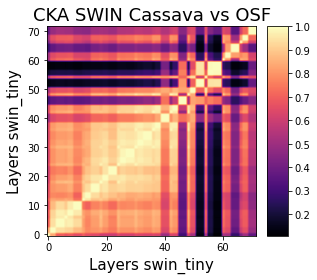

In [23]:
with open('./swin.json', 'r', encoding='utf-8') as fp:
    info = json.load(fp)
save_path = "./swin.png"
model1_info = info["model1_name"]
model2_info = info["model2_name"]
title = "CKA SWIN Cassava vs OSF"
hsic_matrix = info["CKA"]
plot_results(save_path, title, model1_info, model2_info, hsic_matrix)